# Прогнозирование количества запросов в Google и Яндекс поиске с помощью библиотеки машинного обучения Prophet и NeuralProphet

### Мне стало интересно, можно ли получить правдоподобные выводы из открытой информации, взятой из вышеупомянутых источников, об определённом товаре
### Я решил сделать некое исследование использовав библиотеку машинного обучения, которая прогнозирует временные ряды.
#### К тому же, в этом исследовательском проекте я улучшил свои навыки в EDA (Explaratory Data Analysis), что тоже приятно :)

### Импорт библиотек

In [369]:
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt

### Чтение изначального файла с данными из Google Trends
##### Удаление 1 ненужной строки в csv файле

In [370]:
df = pd.read_csv('Google_data.csv', skiprows=1)
df

,Неделя,товар(Россия)
0,2017-12-17,0
1,2017-12-24,32
2,2017-12-31,0
3,2018-01-07,0
4,2018-01-14,44
...,...,...
255,2022-11-06,31
256,2022-11-13,0
257,2022-11-20,14
258,2022-11-27,13


##### Замена строк с нулём на среднее значение(вероятно в эти месяцы не поступала информация о запросах)
##### Приведение даты к формату дататайма(чтобы пропхет мог скушать мой датафрейм)

In [371]:
# вычисление среднего значения
mean_value = df['товар(Россия)'].mean()
df['товар(Россия)'] = df['товар(Россия)'].replace(0, mean_value)

df["Неделя"] = pd.to_datetime(df["Неделя"].astype("str"), format="%Y/%m/%d")

##### Создание датафрейма с дроблением по месяцам

In [372]:
df_monthly = df.rename(columns={'Неделя':'ds', 'товар(Россия)': 'y'})
df_monthly

,ds,y
0,2017-12-17,27.088462
1,2017-12-24,32.000000
2,2017-12-31,27.088462
3,2018-01-07,27.088462
4,2018-01-14,44.000000
...,...,...
255,2022-11-06,31.000000
256,2022-11-13,27.088462
257,2022-11-20,14.000000
258,2022-11-27,13.000000


##### Приведение 4 недель к 1 месяцу и суммирование их значений

In [373]:
df_monthly.groupby([df_monthly["ds"].dt.to_period('M')]).sum()

,y
ds,
2017-12,86.176923
2018-01,111.088462
2018-02,95.000000
2018-03,92.176923
2018-04,111.088462
...,...
2022-08,149.000000
2022-09,189.000000
2022-10,222.000000


##### Переименование датафрейма с неделями

In [374]:
df_weekly = df.rename(columns={'Неделя':'ds', 'товар(Россия)': 'y'})
df_weekly

,ds,y
0,2017-12-17,27.088462
1,2017-12-24,32.000000
2,2017-12-31,27.088462
3,2018-01-07,27.088462
4,2018-01-14,44.000000
...,...,...
255,2022-11-06,31.000000
256,2022-11-13,27.088462
257,2022-11-20,14.000000
258,2022-11-27,13.000000


## Prophet
### Тренировка модели обычного пропхета для недельного предсказания

In [375]:
prophet_model_weekly = Prophet()
prophet_model_weekly.fit(df_weekly)

23:49:49 - cmdstanpy - INFO - Chain [1] start processing
23:49:49 - cmdstanpy - INFO - Chain [1] done processing


#### Какие последние числа будут предсказываться?

In [376]:
future = prophet_model_weekly.make_future_dataframe(periods=300)
future.tail()

,ds
555,2023-09-26
556,2023-09-27
557,2023-09-28
558,2023-09-29
559,2023-09-30


#### Вывод предсказаний(последних несколько) по "понедельной" модели

In [377]:
forecast = prophet_model_weekly.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
555,2023-09-26,49.532476,31.390358,68.377612
556,2023-09-27,49.449896,31.037386,67.444758
557,2023-09-28,49.349438,32.850692,67.607792
558,2023-09-29,49.231775,29.654523,68.004139
559,2023-09-30,49.097516,31.207295,66.187209


# Предсказания в виде графика!!! картинкиии :)

In [378]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(prophet_model_weekly, forecast)

#график по weekly df

## 1. График с многолетней тенденцией
## 2. График сезонности

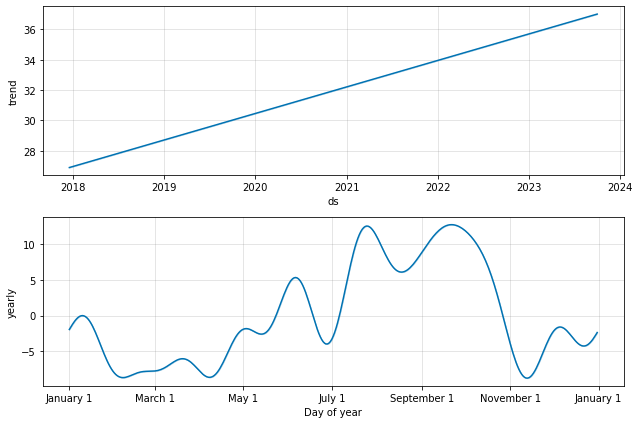

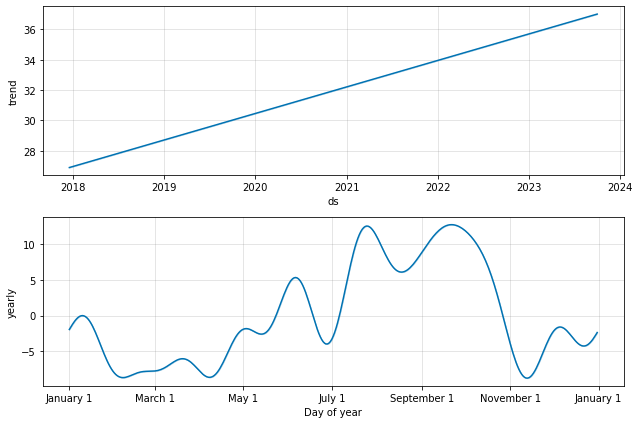

In [379]:
prophet_model_weekly.plot_components(forecast)

## NeuralProphet

#### У меня есть инфа с GoogleTrends - df_monthly, которую я предварительно преобразовал, и инфа с Яндекс вордстата


##### Чтение csv с Яндекс вордстата

In [380]:
Yandf = pd.read_csv('yandex_inf.csv', sep=';', header=0, names=['ds','absolute', 'relative_values'], decimal=',')

#### Преобразование датафрейма Яндекса: абсолютные значения приводятся к виду процентов, где 100% - максимальное абсолютное значение запросов

###### Удаление колонки с относительными значениями(Для получения относительного значения абсолютная цифра нормируется на количество показов результатов поиска Яндекса за соответствующий месяц) из таблицы, так как, вероятно, что она будет хуже подходить для прогнозирования количества запросов в будущем

In [381]:
Yandf.drop(columns = 'relative_values', inplace=True)

Yandf['absolute_percentage']=Yandf['absolute']/np.amax(Yandf['absolute'])*100
Yandf

,ds,absolute,absolute_percentage
0,01.01.2021 - 31.01.2021,182,36.472946
1,01.02.2021 - 28.02.2021,179,35.871743
2,01.03.2021 - 31.03.2021,183,36.673347
3,01.04.2021 - 30.04.2021,180,36.072144
4,01.05.2021 - 31.05.2021,243,48.697395
5,01.06.2021 - 30.06.2021,264,52.905812
6,01.07.2021 - 31.07.2021,358,71.743487
7,01.08.2021 - 31.08.2021,341,68.336673
8,01.09.2021 - 30.09.2021,499,100.000000
9,01.10.2021 - 31.10.2021,353,70.741483


#### Решил сделать 2 разных модели по 2 датафреймам от яндекса и гугла и сравнить

##### Удаление ненужного промежутка " - 30.11.2022" (по типу такого)

In [382]:
Yandf['ds']=Yandf['ds'].astype(str).str[:10]

##### Преобразование дф.дс к формату дататайма

In [383]:
Yandf["ds"] = pd.to_datetime(Yandf["ds"].astype("str"), format="%d.%m.%Y")

##### Удаление столбца 'absolute' для корректной работы модели

In [384]:
Yand = Yandf.copy()
Yand = Yand.rename(columns={'absolute_percentage': 'y'})
Yand.drop(columns = 'absolute', inplace=True)
Yand

,ds,y
0,2021-01-01,36.472946
1,2021-02-01,35.871743
2,2021-03-01,36.673347
3,2021-04-01,36.072144
4,2021-05-01,48.697395
5,2021-06-01,52.905812
6,2021-07-01,71.743487
7,2021-08-01,68.336673
8,2021-09-01,100.000000
9,2021-10-01,70.741483


#### Yand - Яндекс и df_monthly - Google

#### Модель NeuralProphet для Яндекс вордстата

In [385]:
m_Yan = NeuralProphet()
Nmetrics_Yan = m_Yan.fit(Yand, freq='M')
Nforecast_Yan = m_Yan.predict(Yand)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 86.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (2) is too small than the required number for the learning rate fi

Finding best initial lr:   0%|          | 0/202 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 86.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 86.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 2it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


## Модель NeuralProphet для Google трендс
##### Датафрейм Гугла

In [386]:
df_monthly

,ds,y
0,2017-12-17,27.088462
1,2017-12-24,32.000000
2,2017-12-31,27.088462
3,2018-01-07,27.088462
4,2018-01-14,44.000000
...,...,...
255,2022-11-06,31.000000
256,2022-11-13,27.088462
257,2022-11-20,14.000000
258,2022-11-27,13.000000


In [387]:
m_ggl = NeuralProphet()
metrics_ggl = m_ggl.fit(df_monthly, freq='M')
forecast_ggl = m_ggl.predict(df_monthly)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency M is different than major frequency W-SUN
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 322
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (17) is too small than the required number for the learning rate finder (213). The results might not be optimal.


Finding best initial lr:   0%|          | 0/213 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency M is different than major frequency W-SUN
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency M is different than major frequency W-SUN


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


## В Яндекс вордстате оказалось слишком мало данных, для нормальных предсказаний

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 86.957% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 86.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 86.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 2it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


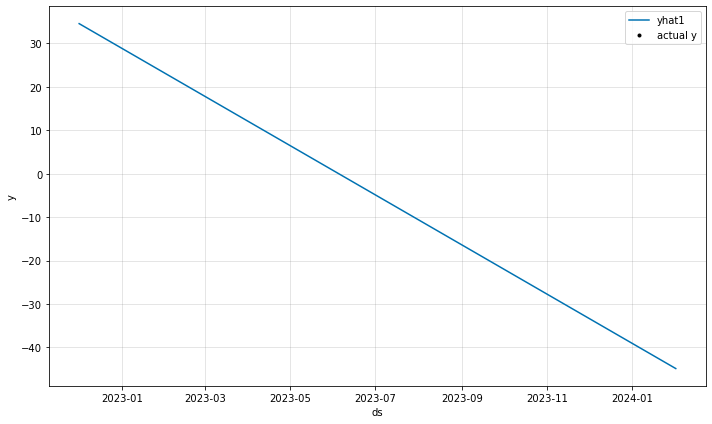

In [388]:
Ndf_future_Yan = m_Yan.make_future_dataframe(Yand, periods=15)
Nforecast_Yan = m_Yan.predict(Ndf_future_Yan)
Nfig_forecast_Yan = m_Yan.plot(Nforecast_Yan)

## Из Google Trends данных для предсказаний хватило (но я всё же считаю, что я рассматривал товар, у которого недостаточно данных для серьёзных выводов, исходя из предсказаний)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.615% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency M is different than major frequency W-SUN
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


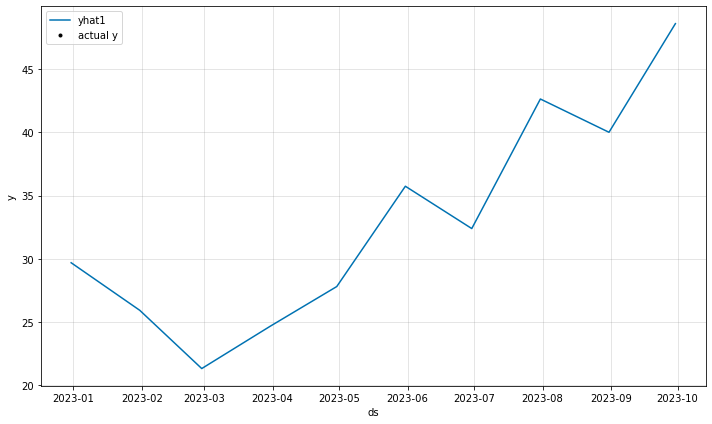

In [389]:
df_future_ggl = m_ggl.make_future_dataframe(df_monthly, periods=10)
forecast_ggl = m_ggl.predict(df_future_ggl)
fig_forecast_ggl = m_Yan.plot(forecast_ggl)

## Решил сравнить обычный Prophet с NeuralProphet на данных от Яндекс Вордстата
##### Тренирую модель обычного пропхета для Yandex

In [390]:
prophet_model_Yan = Prophet().fit(Yand)

23:50:52 - cmdstanpy - INFO - Chain [1] start processing
23:50:52 - cmdstanpy - INFO - Chain [1] done processing


##### Смотрю какие последние месяцы будут предсказываться

In [391]:
future_Yan = prophet_model_Yan.make_future_dataframe(periods=150)
future_Yan.tail()

,ds
168,2023-03-27
169,2023-03-28
170,2023-03-29
171,2023-03-30
172,2023-03-31


In [392]:
forecast_Yan = prophet_model_Yan.predict(future_Yan)
forecast_Yan[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
168,2023-03-27,59.392196,36.167051,83.099570
169,2023-03-28,59.405661,36.411667,84.052775
170,2023-03-29,59.419125,34.360100,81.416728
171,2023-03-30,59.432590,35.559490,82.674448
172,2023-03-31,59.446055,35.320341,83.810865


## График обычного Prophet для Яндекс Вордстата:

In [393]:
plot_plotly(prophet_model_Yan, forecast_Yan)

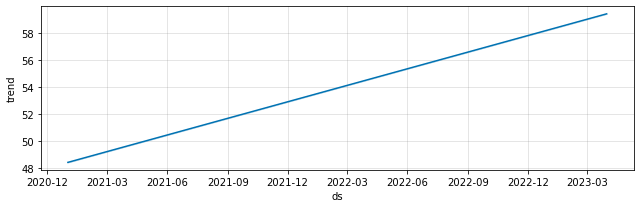

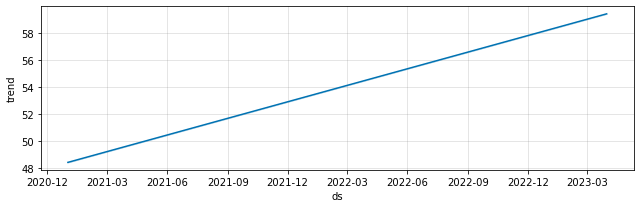

In [394]:
prophet_model_Yan.plot_components(forecast_Yan)

## Вывод: мало данных - мало выводов

# А если серьёзно, то вот какие 7 выводов я смог для себя сделать:
### 1. Из таких источников можно сделать некоторые выводы, однако НЕ стоит выбирать узкоспециализированный товар, по которому поступает суммарно относительно мало запросов от людей.
### 2. При сравнении предсказаний от NeuralProphet(NP) и Prophet(ну и ещё почитав интернет), можно сделать вывод, что NP следует использовать для гораздо более больших массивов данных.
### 3. Запустить модельку гораздо проще, чем подготовить к ней данные.
### 4. Хоть корелляция между покупками и количеством запросов в поисковике существует, но делать из этого выводы крайне опасно :)
### 5. EDA, машинное обучение и нейронки (хоть их я тут и не сильно прочуствовал) крайне интересны!
### 6. Улучшил свои навыки в работе с GitHub.
### 7. Научился оформлять ипунб файлики.

#